## Step 1: Import libraries

In [12]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from scipy import ndimage
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, \
    GlobalAveragePooling3D, BatchNormalization, Dropout, \
        UpSampling3D, concatenate, Flatten, ConvLSTM2D, Bidirectional, \
            Cropping3D, ZeroPadding3D, Activation, Input, UpSampling3D, \
                Conv3DTranspose
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

%matplotlib inline

## Step 2: Set Constants

In [3]:
# set constants
SEED = 137

# [40:195,35:225,26:137]
# constants to crop images

MIN_WIDTH = 29 # 40
MAX_WIDTH = 215 # 195

MIN_HEIGHT = 45 # 35
MAX_HEIGHT = 239 # 225

MIN_DEPTH = 15 # 26
MAX_DEPTH = 143 # 137

## Step 3: Load Data

In [4]:
# load data
df = pd.read_pickle("../raw_data/Grade_ID_nii.pkl")

# the target columns have to be updated, it's only the fremework
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'HGG' else 1)

## Step 4: EDA

In [5]:
print(f"Number of samples: {df['nii'].shape[0]}")
print(f"Negative examples: {df[df['Grade'] == 0].shape}")
print(f"Positive examples: {df[df['Grade'] == 1].shape}")

print("")
print("Single example Shape:")
print(f"Height: {df['nii'][0].shape[0]}")
print(f"Width: {df['nii'][0].shape[1]}")
print(f"Depth: {df['nii'][0].shape[2]}")

Number of samples: 369
Negative examples: (293, 3)
Positive examples: (76, 3)

Single example Shape:
Height: 240
Width: 240
Depth: 155


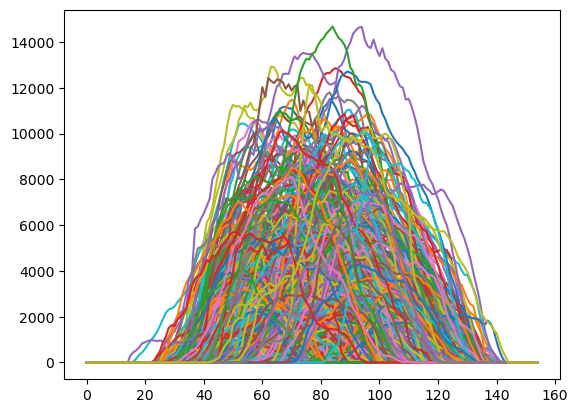

Defined limits: min - 15; max - 143


In [6]:
# code to calculate crop parameters for depth
non_zero = []
min_value = []
max_value = []

for n_image in range(df['nii'].shape[0]):
    image = df['nii'][n_image]
    image_depth_sum = [np.sum(image[:,:,i]) for i in range(image.shape[2])]
    non_zero.append(np.nonzero(image_depth_sum)[0].shape[0])
    min_value.append(np.min(np.nonzero(image_depth_sum)[0]))
    max_value.append(np.max(np.nonzero(image_depth_sum)[0]))
    plt.plot(image_depth_sum)
plt.show()
# here we calculate limits for the depth parameter, but similarly 
# limits can be found for other parameters as well
print(f"Defined limits: min - {np.min(min_value)}; max - {np.max(max_value)}")

In [ ]:
# code to calculate crop parameters for depth
non_zero = []
min_value = []
max_value = []

for n_image in range(df['nii'].shape[0]):
    image = df['nii'][n_image]
    image_depth_sum = [np.sum(image[:,:,i]) for i in range(image.shape[2])]
    non_zero.append(np.nonzero(image_depth_sum)[0].shape[0])
    min_value.append(np.min(np.nonzero(image_depth_sum)[0]))
    max_value.append(np.max(np.nonzero(image_depth_sum)[0]))
    plt.plot(image_depth_sum)
plt.show()
# here we calculate limits for the depth parameter, but similarly 
# limits can be found for other parameters as well
print(f"Defined limits: min - {np.min(min_value)}; max - {np.max(max_value)}")

## Step 5: Crop Images and run Augmentation

In [5]:
# crop images
df['nii'] = df['nii'].apply(lambda x: np.array(x[MIN_HEIGHT:MAX_HEIGHT,MIN_WIDTH:MAX_WIDTH,MIN_DEPTH:MAX_DEPTH]))
X = df['nii']
y = df['Grade']

In [6]:
# reshape input data
X = np.array([np.array(val) for val in X])
X = X.reshape(len(X), X[0].shape[0], X[0].shape[1], X[0].shape[2], 1)

In [7]:
def rotate_image(X, y, i):
    angles = [-30, -20, -15, -10, -5, 5, 10, 15, 20, 30] # set the list of angles to rotate image
    angle = random.choice(angles) # take the random angle from the list
    rotated_example = ndimage.rotate(X[i], angle, reshape=False) # run image rotation
    X = np.append(X, np.expand_dims(rotated_example, axis=0), axis=0) # append rotated image
    y = y.append(pd.Series([y[i]]), ignore_index=True) # append label
    
    return X, y

In [8]:
# conduct augmentation
for i in range(len(X)):
    # we run augmentation only for positive examples, i.e. y[i] != 0
    if y[i] == 0:
        pass
    else:
        X,y = rotate_image(X, y, i)
        X,y = rotate_image(X, y, i)

/tmp/ipykernel_37806/1348074226.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(pd.Series([y[i]]), ignore_index=True) # append label


In [10]:
channel='seg'

In [ ]:
# conduct augmentation
if not os.path.isfile(f"{channel}-X.npy"):
    
    for i in range(len(X)):
        # we run augmentation only for positive examples, i.e. y[i] != 0
        if y[i] == 0:
            pass
        else:
            X,y = rotate_image(X, y, i)
            X,y = rotate_image(X, y, i)
    np.save(f"{channel}-X.npy", X) #save the channel-X so we don't need always augument the X
else:   #load the X direkly from npy file
    X = np.load(f"{channel}-X.npy",
                    mmap_mode='r')

In [13]:
#save the channel-X so we don't need always augument the X
if not os.path.isfile(f"{channel}-X.npy"):
    np.save(f"{channel}-X.npy", X)
else:
    X = np.load(f"{channel}-X.npy",
                    mmap_mode='r')

In [ ]:
X_augm_seg_only=
y_augm_seg_only

In [14]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [15]:
X_train.shape

(416, 194, 186, 128, 1)

In [16]:
y_train.value_counts()

0    234
1    182
dtype: int64

## Step 6: Define Model

In [14]:
#initialize model
def initialize_model(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)):
    model = Sequential()
    
    #Add convo layers to the model
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())
    
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.3))
    
    #Add layer with activation

    model.add(Dense(1, activation='sigmoid'))

    #Model compilation
    # initial_learning_rate = 0.0001
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
    # )
    optim=Adam(learning_rate= 0.0005)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])
    return model

In [15]:
model = initialize_model()
model.summary()

2023-03-13 12:24:08.505214: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-13 12:24:08.506576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-13 12:24:08.631347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 12:24:08.633999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.62GiB deviceMemoryBandwidth: 298.08GiB/s
2023-03-13 12:24:08.634059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-13 12:24:08.639136: I tensorflow/stream_executor/platform/default/dso_loade

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 192, 184, 126, 64) 1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 96, 92, 63, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 92, 63, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 94, 90, 61, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 47, 45, 30, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 45, 30, 64)    256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 45, 43, 28, 128)   2

In [16]:
print(f" Size of X_train: {(X_train.size * X_train.itemsize) / 1e9} Gb")

 Size of X_train: 7.685603328 Gb


## Step 7: Train Model

In [17]:
es = EarlyStopping(patience=5, restore_best_weights = True)
history = model.fit(X_train, y_train,
                        epochs = 30,
                        batch_size = 2,
                        callbacks = [es],
                        validation_data=(X_test, y_test),
                        shuffle =True,
                        verbose = 1)

2023-03-13 12:24:23.085281: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 7685603328 exceeds 10% of free system memory.
2023-03-13 12:24:30.301650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-13 12:24:30.302214: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/30


2023-03-13 12:24:31.110978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-13 12:24:31.454558: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-03-13 12:24:33.222972: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-03-13 12:24:33.551217: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


208/208 [==============================] - 173s 759ms/step - loss: 0.6132 - accuracy: 0.6405 - val_loss: 19.3461 - val_accuracy: 0.4381
Epoch 2/30
208/208 [==============================] - 150s 722ms/step - loss: 0.4837 - accuracy: 0.7754 - val_loss: 42.3280 - val_accuracy: 0.4381
Epoch 3/30
208/208 [==============================] - 150s 722ms/step - loss: 0.4217 - accuracy: 0.8020 - val_loss: 35.9177 - val_accuracy: 0.4381
Epoch 4/30
208/208 [==============================] - 150s 721ms/step - loss: 0.4219 - accuracy: 0.7980 - val_loss: 18.5319 - val_accuracy: 0.5619
Epoch 5/30
208/208 [==============================] - 150s 722ms/step - loss: 0.4393 - accuracy: 0.8052 - val_loss: 5.7428 - val_accuracy: 0.4381
Epoch 6/30
208/208 [==============================] - 150s 720ms/step - loss: 0.3870 - accuracy: 0.8368 - val_loss: 18.0669 - val_accuracy: 0.5619
Epoch 7/30
208/208 [==============================] - 150s 720ms/step - loss: 0.3732 - accuracy: 0.8567 - val_loss: 188.2746 - val

In [18]:
#plot the learning curve
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.2)
    ax1.grid(axis="y",linewidth=0.2)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.2)
    ax2.grid(axis="y",linewidth=0.2)    

    plt.show()    

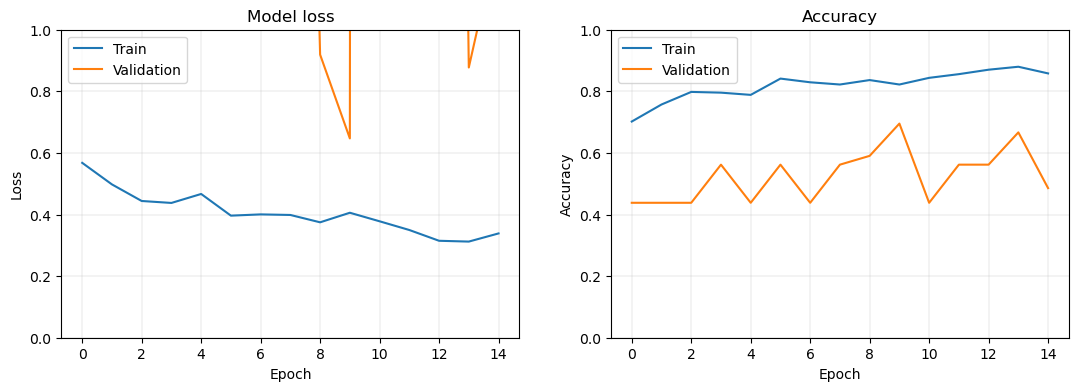

In [19]:
plot_loss(history)

In [20]:
X_test = np.array([np.array(val) for val in X_test])
X_test = X_test.reshape(len(X_test), 194, 186, 128, 1)
X_test.shape

(105, 194, 186, 128, 1)

In [21]:
X_test_small = X_test[:5,:,:,:]
X_test_small.shape

(5, 194, 186, 128, 1)

In [23]:
y_pred_small = model.predict(X_test_small)

2023-03-13 13:14:37.240492: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


In [24]:
predictions = (model.predict(X_test_small) > 0.5).astype("int32")
predictions.shape

In [26]:
y_test_small = y_test[:5]

In [27]:
y_pred_small.shape
y_test_small.value_counts()

0    4
1    1
dtype: int64

In [28]:
model.evaluate(X_test_small, y_test_small)

1/1 [==============================] - 1s 650ms/step - loss: 0.0588 - accuracy: 1.0000


[0.058772165328264236, 1.0]

In [29]:
predictions=pd.DataFrame(predictions)
predictions.value_counts()

0    4
1    1
dtype: int64

In [31]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test_small, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00         4
     class 1       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [33]:
model.save('model_glioma_sve_baseline')

2023-03-13 13:21:32.093486: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_glioma_sve_baseline/assets


In [36]:
loaded_model = load_model('model_glioma_sve_baseline')

# Trying with a UNET model

In [20]:
in_layer = Input((194, 186, 128, 1))
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
cn2 = Conv3D(8, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(cn1)
bn2 = Activation('relu')(BatchNormalization()(cn2))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3], axis=2)

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2], axis=2)

#pre_out
pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'relu')(pre_out)

#pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
#out = ZeroPadding3D((1, 2, 2))(pre_out)
#pre_out = Dense(512, activation = 'relu')(pre_out)    

pre_out = Flatten()(pre_out)

pre_out = Dense(16, activation = 'relu')(pre_out) 
out = Dense(1, activation='sigmoid')(pre_out)
sim_model = Model(inputs = [in_layer], outputs = [out])
sim_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 194, 186, 12 0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 194, 186, 128 4           input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_5 (Conv3D)               (None, 194, 186, 128 208         batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 194, 186, 128 1736        conv3d_5[0][0]                   
____________________________________________________________________________________________

In [21]:
optim=Adam(learning_rate= 0.001)
sim_model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])


In [22]:
es = EarlyStopping(patience=5, restore_best_weights = True)
history = sim_model.fit(X_train, y_train,
                        epochs = 30,
                        batch_size = 2,
                        callbacks = [es],
                        validation_data=(X_test, y_test),
                        shuffle =True,
                        verbose = 1)

2023-03-13 15:57:48.446367: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 7685603328 exceeds 10% of free system memory.


Epoch 1/30


2023-03-13 15:57:56.252581: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-13 15:57:56.919669: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-03-13 15:57:59.575684: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-03-13 15:58:00.023429: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


208/208 [==============================] - 259s 1s/step - loss: 6.9651 - accuracy: 0.5322 - val_loss: 0.6910 - val_accuracy: 0.5619
Epoch 2/30
208/208 [==============================] - 201s 965ms/step - loss: 0.6895 - accuracy: 0.5868 - val_loss: 0.6895 - val_accuracy: 0.5619
Epoch 3/30
208/208 [==============================] - 200s 964ms/step - loss: 0.6878 - accuracy: 0.5825 - val_loss: 0.6885 - val_accuracy: 0.5619
Epoch 4/30
208/208 [==============================] - 201s 964ms/step - loss: 0.6874 - accuracy: 0.5716 - val_loss: 0.6878 - val_accuracy: 0.5619
Epoch 5/30
208/208 [==============================] - 200s 964ms/step - loss: 0.6905 - accuracy: 0.5381 - val_loss: 0.6871 - val_accuracy: 0.5619
Epoch 6/30
208/208 [==============================] - 201s 964ms/step - loss: 0.6840 - accuracy: 0.5848 - val_loss: 0.6867 - val_accuracy: 0.5619
Epoch 7/30
208/208 [==============================] - 201s 964ms/step - loss: 0.6823 - accuracy: 0.5918 - val_loss: 0.6864 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
X_test = np.array([np.array(val) for val in X_test])
X_test = X_test.reshape(len(X_test), 194, 186, 128, 1)
X_test.shape

In [ ]:
X_test_small = X_test[:5,:,:,:]
X_test_small.shape

In [ ]:
y_pred_small = sim_model.predict(X_test_small)
y_pred_small.shape

In [ ]:
predictions = (sim_model.predict(X_test_small) > 0.5).astype("int32")
predictions.shape

In [ ]:
y_test_small = y_test[:5]

In [ ]:
y_test_small.value_counts()

In [ ]:
sim_model.evaluate(X_test_small, y_test_small)

In [ ]:
sim_model.save('model_glioma_unet_sve_base')

In [ ]:
predictions=pd.DataFrame(predictions)
predictions.value_counts()

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test_small, predictions, target_names=target_names))

In [ ]:
loaded_unet_model = load_model('model_glioma_sve_baseline')

In [ ]:
#initialize model
def initialize_unet_model(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)):
    model = Sequential()
    
    #Add convo layers to the model
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())
    
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.3))
    
    #Add layer with activation

    model.add(Dense(1, activation='sigmoid'))

    #Model compilation
    # initial_learning_rate = 0.0001
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
    # )
    optim=Adam(learning_rate= 0.0005)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

def unet_3d(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D((2, 2, 2))(conv4)

    # Decoding path
    up5 = UpSampling3D((2, 2, 2))(pool4)
    concat5 = concatenate([conv4, up5], axis=-1)
    conv5 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv5)
    up6 = UpSampling3D((2, 2, 2))(conv5)
    concat6 = concatenate([conv3, up6], axis=-1)
    conv6 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv6)
    up7 = UpSampling3D((2, 2, 2))(conv6)
    concat7 = concatenate([conv2, up7], axis=-1)
    conv7 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv7)
    up8 = UpSampling3D((2, 2, 2))(conv7)
    concat8 = concatenate([conv1, up8], axis=-1)
    conv8 = Conv3D(32, (3, 3, 3), activation='relu', padding='same
